In [3]:
import scanpy as sc

from gene_trajectories.run_dm import run_dm
from gene_trajectories.get_graph_distance import get_graph_distance
from gene_trajectories.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectories.extract_gene_trajectory import get_gene_embedding
from gene_trajectories.extract_gene_trajectory import extract_gene_trajectory


In [4]:
adata = sc.read_h5ad('/Users/fra/bioinfo/IGT/e14_init.h5ad')


/Users/fra/PycharmProjects/PGT/.venv/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


/Users/fra/PycharmProjects/PGT/.venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/fra/PycharmProjects/PGT/.venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/fra/PycharmProjects/PGT/.venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(val

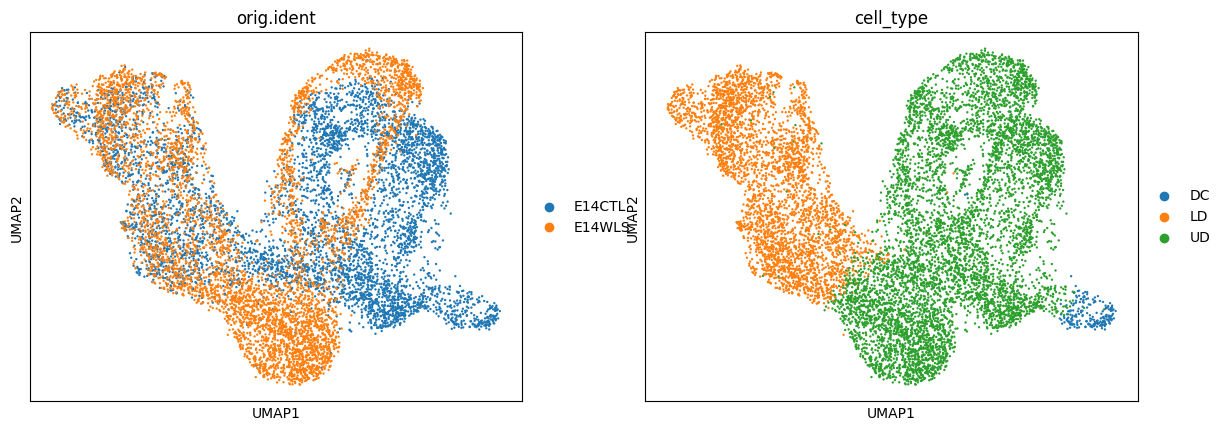

In [34]:
sc.pl.umap(adata, color=["orig.ident", "cell_type"])

In [5]:
assert 'X_dm' not in adata.obsm

In [6]:
run_dm(adata)

In [7]:
assert adata.obsm['X_dm'].shape == (10328, 30)

In [8]:
cell_graph_dist = get_graph_distance(adata, k=10)

The largest graph distance is 67


In [9]:
if 'counts' not in adata.layers:
    adata.layers['counts']=adata.raw.X.copy()

In [10]:
genes = select_top_genes(adata, layer='counts')

In [11]:
assert len(genes) == 1177

In [12]:
gene_expression_updated, graph_dist_updated = coarse_grain_adata(adata, graph_dist=cell_graph_dist, features=genes, dims=10)

In [13]:
from gene_trajectories.gene_distance_calculate import init_global_from_np, cal_ot_mat

In [14]:
init_global_from_np(gene_expr=gene_expression_updated, ot_cost=graph_dist_updated)
gene_dist_mat = cal_ot_mat(show_progress_bar=True)

Computing emd distance..


100%|██████████| 692076/692076 [34:50<00:00, 331.03it/s]  


Program finished in 2098.55210375 seconds - using multiprocessing
---


In [15]:
assert gene_dist_mat.shape == (1177, 1177)

In [16]:
gene_dist_mat[:3,:3]

array([[ 0.        , 13.75420208, 10.7308441 ],
       [13.75420208,  0.        , 16.37855916],
       [10.7308441 , 16.37855916,  0.        ]])

In [17]:
genes[:3]

array(['Hist1h1b', 'Hbb-bt', 'Cenpf'], dtype=object)

In [28]:


gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)


In [29]:

gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, gene_names=genes,
                                          n = 3, t_list = [9,16,5], k = 5)


Generating trajectory from Sox2
Generating trajectory from Hist1h2af
Generating trajectory from Akr1c14


In [31]:
gene_trajectory

,DM_1,DM_2,DM_3,DM_4,DM_5,selected,Pseudoorder-1,Pseudoorder-2,Pseudoorder-3
Hist1h1b,-0.009979,0.012023,-0.036495,0.009393,-0.008197,Trajectory-2,0.0,646.0,0.0
Hbb-bt,0.000948,0.002318,0.001329,-0.000958,0.000461,Trajectory-2,0.0,193.0,0.0
Cenpf,-0.027441,-0.012038,0.009466,-0.001651,-0.004299,Trajectory-2,0.0,769.0,0.0
Ube2c,-0.023017,-0.007474,0.004321,-0.000664,-0.000955,Trajectory-2,0.0,739.0,0.0
Dqx1,-0.000553,0.003997,0.000765,-0.000743,0.003468,Trajectory-2,0.0,501.0,0.0
...,...,...,...,...,...,...,...,...,...
Pcnt,-0.001841,0.004051,0.000192,-0.000615,0.003941,Trajectory-2,0.0,563.0,0.0
Cep70,-0.005011,0.001568,0.001401,-0.000786,0.002436,Trajectory-2,0.0,604.0,0.0
Ctnna2,-0.000809,0.004823,0.000832,-0.000718,0.005035,Trajectory-2,0.0,517.0,0.0
Ets1,-0.000387,0.004587,0.001246,-0.000885,0.004624,Trajectory-2,0.0,472.0,0.0


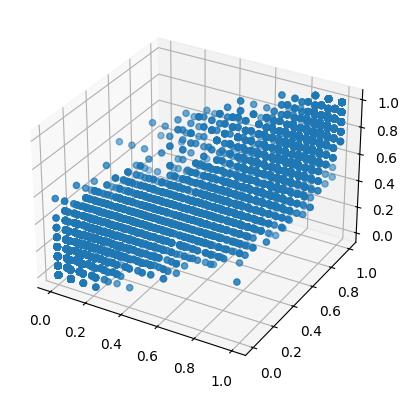

In [36]:
from matplotlib import pyplot as plt

ax = plt.axes(projection='3d')
ax.scatter(xs=adata.obs['Trajectory1_genes1'],
           ys=adata.obs['Trajectory1_genes2'],
           zs=adata.obs['Trajectory1_genes3'],)
